In [1]:
import pints
import pints.toy as toy
import pints.plot

import emupints
import emupints.plot as emuplt
import emupints.utils as emutils
import emupints.metrics as emumet

from emupints.models import create_small_model, create_average_model, create_large_model

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras

import string

# Problem parameters

In [2]:
# Load problem from predefined ones
model = emupints.Problems.LotkaVolterraModel
problem = emupints.Problems.load_problem(model)

problem['values'][:5]

array([[1.9399722 , 1.96690843],
       [1.99643223, 2.04093468],
       [1.84335328, 1.9771459 ],
       [1.94276639, 1.95293273],
       [1.92750833, 2.11452946]])

In [3]:
# take all the required variables from the problem
n_parameters = problem['n_parameters']
log_likelihood = problem['log_likelihood']
log_prior = problem['log_prior']
log_posterior = problem['log_posterior']
real_parameters = problem['parameters']
pints_problem = problem['problem']
bounds = problem['bounds']
index_to_param_name = problem['param_names']

# Apply CMA-ES

In [4]:
# CMA-es
score = pints.SumOfSquaresError(pints_problem)
x0 = bounds.sample(1)[0]

found_parameters, found_value = pints.optimise(
    score,
    x0,
    None,
    bounds,
    method=pints.CMAES
)

Minimising error measure
using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 8
Iter. Eval. Best      Time m:s
0     8      25.73252   0:00.1
1     16     14.30105   0:00.1
2     24     6.643973   0:00.1
3     32     6.235383   0:00.1
20    168    1.539496   0:00.2
40    328    1.484867   0:00.3
60    488    1.388556   0:00.5
80    648    1.385965   0:00.6
100   808    1.385962   0:00.7
120   968    1.385962   0:00.8
140   1128   1.385962   0:01.0
160   1288   1.385962   0:01.1
180   1448   1.385962   0:01.2
200   1608   1.385962   0:01.4
220   1768   1.385962   0:01.5
240   1928   1.385962   0:01.6
260   2088   1.385962   0:01.8
280   2248   1.385962   0:01.9
300   2408   1.385962   0:02.0
319   2552   1.385962   0:02.1
Halting: No significant change for 200 iterations.


# Use found parameters to sample trianing data

In [5]:
# training size
# use bigger training size for NNs because speed stays the same
train_size = 3000
test_size = 400
sampling_std = 0.05 * found_parameters # take 0.05% around found parameters std

def normal_sampling(size, mean, std):
    return mean + np.random.randn(*size) * std

# create data for training and testing
# genera example using normal distribution around parametrs
train_X = normal_sampling((train_size, n_parameters), found_parameters, sampling_std)
train_y = np.apply_along_axis(log_likelihood, 1, train_X)

# if provide validation data to keras model also need to normalize it 
test_X = normal_sampling((test_size, n_parameters), found_parameters, sampling_std)
test_y = np.apply_along_axis(log_likelihood, 1, test_X)

# Create NN emulator

In [6]:
EPOCHS = 50
BATCH = 16
validation_split = 0.2

In [7]:
# how to scale data
# for input use standardisation, same as GPs
# for output scale linearly in range (-1, 1)
input_scaler = MinMaxScaler(feature_range=(-1, 1))
output_scaler = StandardScaler()

In [8]:
emu = emupints.NNEmulator(log_likelihood, 
                          train_X,
                          train_y,
                          model_size='small',
                          input_scaler=input_scaler, 
                          output_scaler=output_scaler
                         )

In [9]:
# print summary of the model
emu.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [10]:
# store best
mc_callback = keras.callbacks.ModelCheckpoint("models/model_{epoch:02d}.h5", 
                                              save_weights_only=True,  
                                             )

In [11]:
# store the results during training
val_umae = []

# Callback to calculate unormalized mae
class UnormalizedMAE(keras.callbacks.Callback):

    def on_epoch_end(self, batch, logs={}):
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        
        y_val_predict = np.asarray(self.model.predict(X_val))

        # unormalize predictions
        y_val = output_scaler.inverse_transform(y_val)
        y_val_predict = output_scaler.inverse_transform(y_val_predict)

        # calculate mae
        mae_val = np.mean(np.abs(y_val - y_val_predict))

        # store results
        val_umae.append(mae_val)

        return

In [12]:
#optimizer = tf.train.RMSPropOptimizer(learning_rate)
emu.set_parameters(
    loss='mse',
    optimizer='adam',
    metrics=['mae'] # mean absolute error
)

In [13]:
history = emu.fit(epochs=EPOCHS,
                  batch_size=BATCH,
                  validation_split=0.2,
                  callbacks=[mc_callback,UnormalizedMAE()],
                 )

Train on 2400 samples, validate on 600 samples
Epoch 1/50
2400/2400 [==============================] - 1s 214us/step - loss: 1.4433 - mean_absolute_error: 0.4825 - val_loss: 0.6372 - val_mean_absolute_error: 0.2279
Epoch 2/50
2400/2400 [==============================] - 0s 89us/step - loss: 0.4480 - mean_absolute_error: 0.1706 - val_loss: 0.3460 - val_mean_absolute_error: 0.1493
Epoch 3/50
2400/2400 [==============================] - 0s 100us/step - loss: 0.2950 - mean_absolute_error: 0.1266 - val_loss: 0.2668 - val_mean_absolute_error: 0.1385
Epoch 4/50
2400/2400 [==============================] - 0s 94us/step - loss: 0.2380 - mean_absolute_error: 0.1082 - val_loss: 0.2313 - val_mean_absolute_error: 0.1106
Epoch 5/50
2400/2400 [==============================] - 0s 95us/step - loss: 0.2093 - mean_absolute_error: 0.1006 - val_loss: 0.1962 - val_mean_absolute_error: 0.0842
Epoch 6/50
2400/2400 [==============================] - 0s 91us/step - loss: 0.1927 - mean_absolute_error: 0.1097 - 

2400/2400 [==============================] - 0s 96us/step - loss: 0.0909 - mean_absolute_error: 0.0668 - val_loss: 0.0896 - val_mean_absolute_error: 0.0543
Epoch 50/50
2400/2400 [==============================] - 0s 87us/step - loss: 0.0896 - mean_absolute_error: 0.0665 - val_loss: 0.0941 - val_mean_absolute_error: 0.0745


In [14]:
best_model_idx = np.argmin(val_umae)
emu._model.load_weights("models/model_{:02d}.h5".format(best_model_idx))

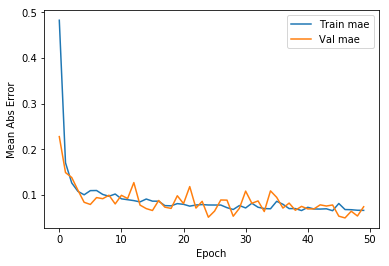

In [15]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
       label='Train mae')
plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
       label = 'Val mae')
plt.legend()

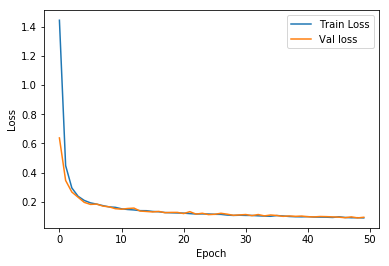

In [16]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.epoch, np.array(history.history['loss']),
       label='Train Loss')
plt.plot(history.epoch, np.array(history.history['val_loss']),
       label = 'Val loss')
plt.legend()

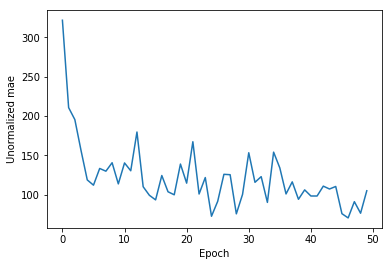

In [17]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Unormalized mae')
plt.plot(history.epoch, val_umae)

# Likelihood metrics

In [18]:
emu_time = %timeit -r 50 -o emu(real_parameters)
print("Emulator prediction time (micro-seconds): {:5f}".format(emu_time.average * 1000000))

503 µs ± 61.9 µs per loop (mean ± std. dev. of 50 runs, 1000 loops each)
Emulator prediction time (micro-seconds): 502.868711


In [ ]:
likelihood_time = %timeit -r 50 -o log_likelihood(real_parameters)
print("Likelihood prediction time (micro-seconds): {:5f}".format(likelihood_time.average * 1000000))

3.01 ms ± 221 µs per loop (mean ± std. dev. of 50 runs, 100 loops each)
Likelihood prediction time (micro-seconds): 3014.629675


In [ ]:
pred_y = np.apply_along_axis(emu, 1, test_X)
print("Mean absolute error (mae): {:.5f}".format(emumet.mae(test_y, pred_y)))

Mean absolute error (mae): 1292.56785


In [ ]:
print("Mean percentage error (mape): {:.5f}".format(emumet.mape(test_y, pred_y) * 100))

Mean percentage error (mape): 628.10461


# Comparing MCMC run times

In [ ]:
mcmc_method = pints.AdaptiveCovarianceMCMC

# MCMC parameters
num_chains = 3
max_iters = 10000

In [ ]:
# Create a posterior log-likelihood (log(likelihood * prior))
emu_log_posterior = pints.LogPosterior(emu, log_prior)

In [ ]:
xs = [
    found_parameters,
    found_parameters * 1.01,
    found_parameters * 0.99
]
xs

[array([3.05640617, 2.03190682, 2.94223346, 1.96056029]),
 array([3.08697023, 2.05222588, 2.9716558 , 1.9801659 ]),
 array([3.02584211, 2.01158775, 2.91281113, 1.94095469])]

In [ ]:
emu_mcmc = pints.MCMCSampling(emu_log_posterior,
                              num_chains,
                              xs,
                              method = mcmc_method,
                             )
emu_mcmc.set_log_to_screen(False)
print('Running...')
emu_chains = emu_mcmc.run()
print('Done!')

Running...
Done!


In [ ]:
real_mcmc = pints.MCMCSampling(log_posterior, 
                               num_chains, 
                               xs, 
                               method = mcmc_method,
                               )
real_mcmc.set_max_iterations(max_iters)
real_mcmc.set_log_to_screen(False)
# Run!
print('Running...')
real_chains = real_mcmc.run()
print('Done!')

Running...
Done!


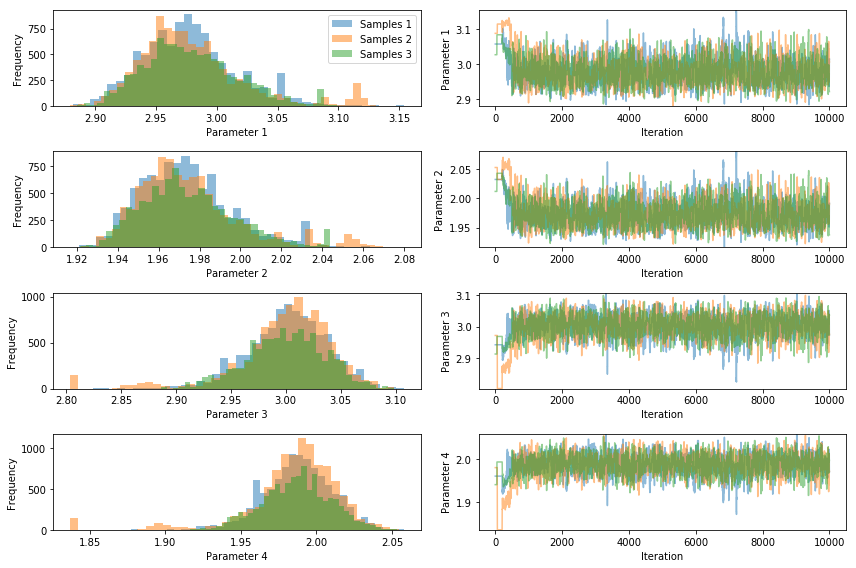

In [ ]:
pints.plot.trace(emu_chains)
plt.show()

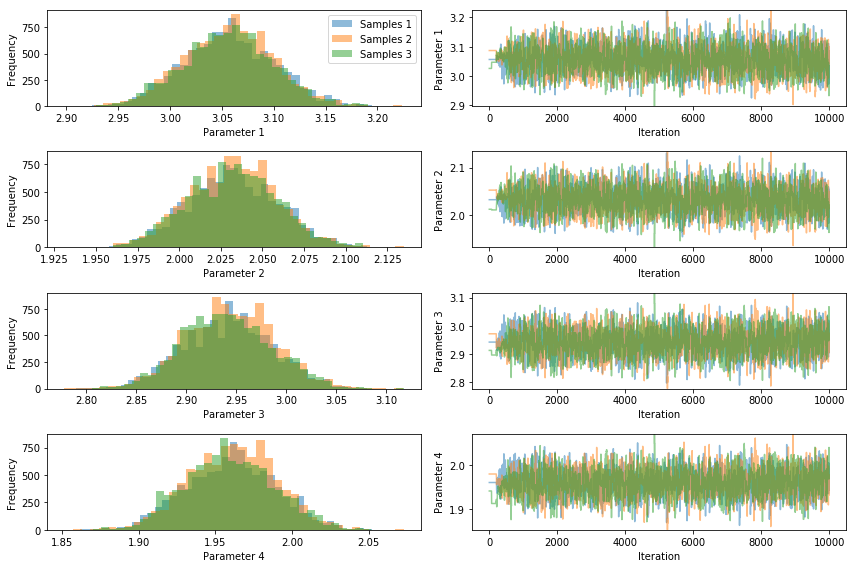

In [ ]:
pints.plot.trace(real_chains)
plt.show()

# MCMC metrics

In [ ]:
print('Emulator R-hat:')
print(pints.rhat_all_params(emu_chains))

Emulator R-hat:
[1.000222177620961, 1.0001510912059572, 1.0006831180610727, 1.0010854848826065]


In [ ]:
print('Real R-hat:')
print(pints.rhat_all_params(real_chains))

Real R-hat:
[1.0000229001778635, 1.0000244873111366, 1.000563895162322, 1.000952771698826]


In [ ]:
# percentage
chain = real_chains[0]

chain_mape = emumet.chain_mape(chain, emu, log_likelihood)
print("Chain mean absolute percentage error: {:.5f}".format(chain_mape * 100))

Chain mean absolute percentage error: 1.24044


In [ ]:
emu_mcmc_time = %timeit -o emu_mcmc.run()
print("Emulator MCMC time: {:.5f}".format(emu_mcmc_time.average))

22.2 s ± 3.83 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Emulator MCMC time: 22.15804


In [ ]:
real_mcmc_time = %timeit -o real_mcmc.run()
print("MCMC time: {:.5f}".format(real_mcmc_time.average))

28.2 s ± 1.25 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
MCMC time: 28.20898


In [ ]:
emu_parameters, emu_parameters_std = emumet.estimate_parameters(emu_chains)
print("Emulator estimated parameters: ", emu_parameters)
print("Emulator parametet std: ", emu_parameters_std)

Emulator estimated parameters:  [2.97885691 1.9741941  3.00039968 1.98647349]
Emulator parametet std:  [0.00279403 0.00109294 0.00464586 0.00412019]


In [ ]:
real_parameters, real_parameters_std = emumet.estimate_parameters(real_chains)
print("Estimated parameters: ", real_parameters)
print("parametet std: ", real_parameters_std)

Estimated parameters:  [3.05681249 2.03221255 2.942214   1.96031335]
parametet std:  [0.00049015 0.00031482 0.00044908 0.00031283]


# Plotting emulator surfaces around parameters

In [ ]:
# use smaller bounds to get an idea of the surface around real parameters
min_bounds = np.min(chain, axis = 0)
max_bounds = np.max(chain, axis = 0)
bounds = pints.RectangularBoundaries(min_bounds, max_bounds)

In [ ]:
bounds

In [ ]:
# plot surfaces
if n_parameters >= 3:
    fixed_parameters = emutils.fix_parameters(bounds)
    
    fig, ax = emuplt.plot_fixed_param_grid(
        emu,
        fixed_parameters,
        bounds,
        shape = (n_parameters, n_parameters - 1),
        contour = False,
        index_to_param_name=index_to_param_name,
        additional_log_likelihoods = [log_likelihood]
    )

    plt.show(fig)
    
# for row i we have parameter i fixed and some other parameter j, depending on the column, j != i

In [ ]:
print(bounds.lower())
print(bounds.upper())

In [ ]:
fig, ax = emuplt.plot_surface_fixed_param(
    emu,
    bounds,
    #fixed = [(1, 0.29)],
    index_to_param_name=index_to_param_name,
    contour=False,
    precision=2,
    additional_log_likelihoods=[log_likelihood]
)

In [ ]:
ax.view_init(30, 45 + 90 *3)
fig.set_size_inches(10.5, 6)
fig